In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from sklearn import linear_model
from tqdm import tqdm

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
def plot_dual(img1, img2, title1='', title2='', figsize=(15,5)): 
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    f.tight_layout()
    ax1.imshow(img1) 
    ax1.set_title(title1)
    ax2.imshow(img2)
    
def test_calibration(objpoints, imgpoints):
    num_img = len(camera_cal_list)
    idx = np.random.randint(0,num_img)
    test_img = cv2.imread('./camera_cal/calibration'+str(idx)+'.jpg')
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    dst = cal_undistort(test_img, objpoints, imgpoints)
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.title(camera_cal_list[idx])
    plt.imshow(test_img)
    plt.subplot(1, 2, 2)
    plt.title('Undistorted')
    plt.imshow(dst)
    
def cal_undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [3]:
def camera_calibration(camera_cal_list, nx, ny, img_size=(720,1280)):
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,0:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    for i, image_name in enumerate(camera_cal_list):
        image = cv2.imread('./camera_cal/'+image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return mtx, dist

def perspective_transform(src_points, dst_points):
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    Minv = cv2.getPerspectiveTransform(dst_points, src_points)
    return M, Minv

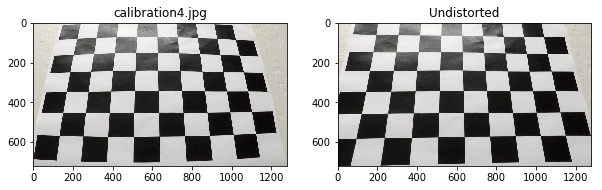

In [4]:
camera_cal_list = os.listdir('./camera_cal')
mtx, dist= camera_calibration(camera_cal_list, 9, 6)
test_calibration(mtx, dist)

## Pipeline (single image)

### 1. Distortion-corrected image

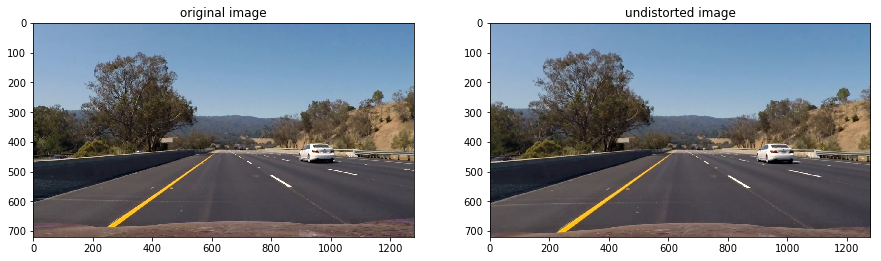

In [5]:
raw_img = cv2.imread('./examples/raw_img.jpg')
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
undistorted_img = cal_undistort(raw_img, mtx, dist)
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.title('original image')
plt.imshow(raw_img)
plt.subplot(1,2,2)
plt.title('undistorted image')
plt.imshow(undistorted_img)


### 2. Using color transforms, gradients to create a thresholded binary image.

In [6]:
def gradient_x(img, kernel_size = 3, thresh=(0,255)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel_size)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary

def preprocess_img(img, sobel_ksize=3):
    img = np.copy(img) #RGB
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    light_mask = np.zeros_like(l_channel)
    light_mask[(s_channel>=5) & (l_channel>=130)] = 1
    gradx_l = gradient_x(l_channel, sobel_ksize, (25, 100))
    gradx_s = gradient_x(s_channel, sobel_ksize, (10, 100))
    combined = np.zeros_like(gradx_s)
    combined[((gradx_l == 1) | (gradx_s == 1)) & (light_mask == 1)] = 1
    color_binary = np.uint8(combined*255)
    return color_binary 

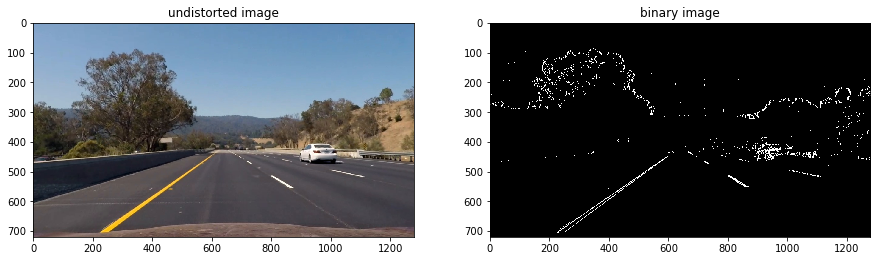

In [7]:
binary_img = preprocess_img(undistorted_img)
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.title('undistorted image')
plt.imshow(undistorted_img)
plt.subplot(1,2,2)
plt.title('binary image')
plt.imshow(binary_img, cmap='gray')

### 3. Perspective transform

In [8]:
def perspective_transform(src_points, dst_points):
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    Minv = cv2.getPerspectiveTransform(dst_points, src_points)
    return M, Minv

def warp_image(img, mtx):
    flag=cv2.INTER_LINEAR
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, mtx, img_size, flag)

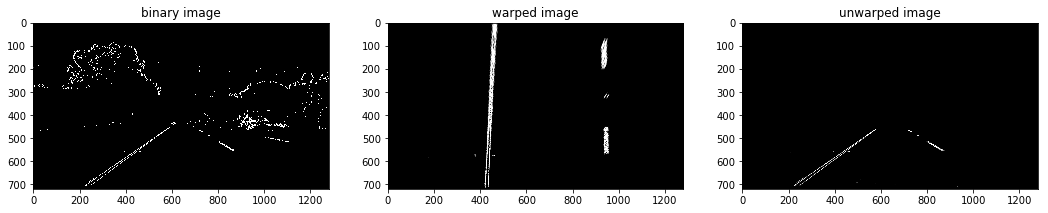

In [9]:
src_pts = np.array([[240,720],[575,460],[715,460],[1150,720]], np.float32)
dst_pts = np.array([[440,720],[440,0],[950,0],[950,720]], np.float32)

M, Minv = perspective_transform(src_pts, dst_pts)
warped_img = warp_image(binary_img, M)
unwarped_img = warp_image(warped_img, Minv)

plt.figure(figsize=(18,8))
plt.subplot(1,3,1)
plt.title('binary image')
plt.imshow(binary_img, cmap='gray')
plt.subplot(1,3,2)
plt.title('warped image')
plt.imshow(warped_img, cmap='gray')
plt.subplot(1,3,3)
plt.title('unwarped image')
plt.imshow(unwarped_img, cmap='gray')

### 3. Identified lane-line pixels and fit their positions with a polynomial

First I use `find_centroids` function to find the centroid in each window. then I use `find_xy` to find the point in each window. At the end of `find_xy` process I fit the lane line.

### 4. Calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

```python
def get_curvature(self, fit, y_eval):
    return ((1 + (2 * fit[0] * y_eval + fit[1]) ** 2) ** 1.5) / np.absolute(2 * fit[0])
def get_dist_center(self, fit):
    xm_per_pix = 3.7/(1280*0.57)
    real_center = (fit[1][2]+fit[0][2])/2
    dist = (640-real_center)*xm_per_pix
    return dist
```

I use `get_curvature` and `get_dist_center` functions to get the curvature and position of the vehicle.

In [10]:
class Line():
    def __init__(self, nwindows, win_width, mtx, dist, M, Minv):
        self.previous_fit_l = []
        self.previous_fit_r = []
        self.previous_fit = []
        self.previous_centroids = []
        self.allx = [] 
        self.ally = [] 
        self.mtx = mtx 
        self.dist= dist 
        self.M = M 
        self.Minv= Minv 
        self.nwindows = nwindows
        self.win_width = win_width
    def find_refwin(self, window_centroids, window_boole):
        num = len(window_centroids)
        center = 0
        for i in range(num, 0, -1):
            if window_boole[i-1] == True:
                center = window_centroids[i-1]
                break
        return center
    def find_centroids(self, img, space_search=100): 
        window = np.ones(self.win_width)
        window_centroids_l = []
        window_centroids_r = []
        window_boole_l = []
        window_boole_r = []
        win_height = img.shape[0]/self.nwindows 
        bottom_sum_l = np.sum(img[int(3*img.shape[0]/4):,:640], axis=0)
        bottom_sum_r = np.sum(img[int(3*img.shape[0]/4):,640:], axis=0)
        conv_signal_l = np.convolve(window, bottom_sum_l)
        conv_signal_r = np.convolve(window, bottom_sum_r)
        center_l = int(np.argmax(conv_signal_l)-self.win_width/2)
        center_r = int(np.argmax(conv_signal_r)-self.win_width/2)+640
        previous_centroids = np.array(self.previous_centroids)
        if self.previous_centroids==[] or abs(center_l-previous_centroids[0,0])<50:
            window_centroids_l.append(center_l)
        else:
            window_centroids_l.append(previous_centroids[0,0])
        if self.previous_centroids==[] or abs(center_r-previous_centroids[1,0])<50:
            window_centroids_r.append(center_r)
        else:
            window_centroids_r.append(previous_centroids[1,0])
        window_boole_l.append(True)
        window_boole_r.append(True)
        for i in range(1, self.nwindows):
            window_ref_l = self.find_refwin(window_centroids_l, window_boole_l)
            window_ref_r = self.find_refwin(window_centroids_r, window_boole_r)
            min_index_l = int(max(window_ref_l-space_search,0))
            max_index_l = int(min(window_ref_l+space_search,640))
            min_index_r = int(max(window_ref_r-space_search,640))
            max_index_r = int(min(window_ref_r+space_search,img.shape[1]))
            start_y = int(img.shape[0]-(i+1)*win_height)
            end_y = int(img.shape[0]-i*win_height)
            image_layer_l = np.sum(img[start_y:end_y, min_index_l:max_index_l],axis=0)
            image_layer_r = np.sum(img[start_y:end_y, min_index_r:max_index_r],axis=0)
            conv_signal_l = np.convolve(window, image_layer_l)
            conv_signal_r = np.convolve(window, image_layer_r)
            offset = int(self.win_width/2)
            window_center_l = np.argmax(conv_signal_l)+min_index_l-offset
            window_center_r = np.argmax(conv_signal_r)+min_index_r-offset
            window_centroids_l.append(window_center_l)
            window_centroids_r.append(window_center_r)
            if abs(window_center_l-window_ref_l)<100:
                window_boole_l.append(True)
            else:
                window_boole_l.append(False)
            if abs(window_center_r-window_ref_r)<100:
                window_boole_r.append(True)
            else:
                window_boole_r.append(False)
        window_centroids = [window_centroids_l,window_centroids_r]
        window_boole = [window_boole_l, window_boole_r]
        self.previous_centroids = window_centroids
        return np.array(window_centroids), np.array(window_boole)
    def find_xy(self, img, window_centroids, window_boole):
        self.allx[:] = []
        self.ally[:] = []
        binary_img = img
        win_height = img.shape[0]/self.nwindows 
        nonzero = binary_img.nonzero()
        nonzeroy = nonzero[0]
        nonzerox = nonzero[1]
        for window in range(2):
            index = 0
            x = []
            y = []
            for i in range(9):
                if window_boole[window,i] == True:
                    center = window_centroids[window,i]
                    start_y = int(img.shape[0]-(i+1)*win_height)
                    end_y = int(img.shape[0]-i*win_height)
                    start_x = int(max(center-self.win_width/2, 0))
                    end_x = int(min(center+self.win_width/2, img.shape[1]))
                    binary_img[start_y:end_y,start_x:end_x] = 128
                    for idx in range(len(nonzerox)):
                        if nonzeroy[idx]>start_y and nonzeroy[idx]<end_y:
                            if nonzerox[idx]>start_x and nonzerox[idx]<end_x:
                                x.append([index,nonzerox[idx]])
                                y.append([index,nonzeroy[idx]])
                                index += 1
            self.allx.append(x)
            self.ally.append(y)
        return binary_img
    def line_fit(self, img, window_boole, margin=30):
        ym_per_pix = 23/img.shape[0]
        previous_fit_l = self.previous_fit_l
        previous_fit_r = self.previous_fit_r
        num_win_l = len([i for i in window_boole[0] if i])
        num_win_r = len([i for i in window_boole[1] if i])
        num_win = [num_win_l, num_win_r]
        out_img = np.zeros((img.shape[0],img.shape[1],3), dtype=np.uint8)
        total_fit = []
        for idx in range(2):
            if num_win[idx]>1:
                y = np.array(self.ally[idx])
                x = np.array(self.allx[idx])
                py = y[:,1]
                px = x[:,1]
                ransac = linear_model.RANSACRegressor(residual_threshold=40, random_state=50)
                ransac.fit(y,x)
                inlier_mask = ransac.inlier_mask_
                outlier_mask = np.logical_not(inlier_mask)
                fit = np.polyfit(py[inlier_mask], px[inlier_mask], 2)
                if idx == 0: #left
                    self.previous_fit_l = fit
                elif idx == 1:#right
                    self.previous_fit_r = fit
                ploty= np.linspace(0, img.shape[0]-1, img.shape[0])
                plotx = fit[0]*ploty**2+fit[1]*ploty+fit[2]
                line_window1 = np.array([np.transpose(np.vstack([plotx-margin, ploty]))])
                line_window2 = np.array([np.flipud(np.transpose(np.vstack([plotx+margin,ploty])))])
                line_pts = np.hstack((line_window1, line_window2))
                out_img[y[:,1], x[:,1],:] = [255, 0, 0]
                out_img[py[inlier_mask], px[inlier_mask], :]= [255, 255, 0]
                out_img[py[outlier_mask], px[outlier_mask], :] = [0, 255, 255]
                cv2.fillPoly(out_img, np.int_([line_pts]), (0, 0, 255))
                total_fit.append(fit)
            else:
                if idx == 0: #left
                    fit = self.previous_fit_l
                elif idx == 1:#right
                    fit = self.previous_fit_r
                ploty= np.linspace(0, img.shape[0]-1, img.shape[0])
                plotx = fit[0]*ploty**2+fit[1]*ploty+fit[2]
                line_window1 = np.array([np.transpose(np.vstack([plotx-margin, ploty]))])
                line_window2 = np.array([np.flipud(np.transpose(np.vstack([plotx+margin,ploty])))])
                line_pts = np.hstack((line_window1, line_window2))
                cv2.fillPoly(out_img, np.int_([line_pts]), (255, 0, 255))
                total_fit.append(fit)
        left_curvature = self.get_curvature(total_fit[0], img.shape[0]*ym_per_pix)
        right_cervature = self.get_curvature(total_fit[1], img.shape[0]*ym_per_pix)
        dist = self.get_dist_center(total_fit)
        return out_img, np.array(total_fit), np.array([left_curvature, right_cervature]), dist
    def equalizeHist(self, img):
        output = np.copy(img)
        output[:,:,0]= cv2.equalizeHist(output[:,:,0])
        output[:,:,1]= cv2.equalizeHist(output[:,:,1])
        output[:,:,2]= cv2.equalizeHist(output[:,:,2])
        return output
    def undistort_img(self, img, mtx, dist):
        return cv2.undistort(img, mtx, dist, None, mtx)
    def warp_image(self, img, mtx):
        flag=cv2.INTER_LINEAR
        img_size = (img.shape[1], img.shape[0])
        return cv2.warpPerspective(img, mtx, img_size, flag)
    def gradient_x(self, img, kernel_size = 3, thresh=(0,255)):
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel_size)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        return sxbinary
    def get_curvature(self, fit, y_eval):
        return ((1 + (2 * fit[0] * y_eval + fit[1]) ** 2) ** 1.5) / np.absolute(2 * fit[0])
    def get_dist_center(self, fit):
        xm_per_pix = 3.7/(1280*0.57)
        real_center = (fit[1][2]+fit[0][2])/2
        dist = (640-real_center)*xm_per_pix
        return dist
    def preprocess_img(self, img, sobel_ksize=3):
        img = np.copy(img) #RGB
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        l_channel = hsv[:,:,1]
        s_channel = hsv[:,:,2]
        light_mask = np.zeros_like(l_channel)
        light_mask[(s_channel>=5) & (l_channel>=130)] = 1
        gradx_l = self.gradient_x(l_channel, sobel_ksize, (25, 100))
        gradx_s = self.gradient_x(s_channel, sobel_ksize, (10, 100))
        combined = np.zeros_like(gradx_s)
        combined[((gradx_l == 1) | (gradx_s == 1)) & (light_mask == 1)] = 1
        color_binary = np.uint8(combined*255)
        return color_binary 
    def find_lane(self, img, sobel_ksize=3):
        undistorted_img = self.undistort_img(img, self.mtx, self.dist)
        preprocessed_img = self.preprocess_img(undistorted_img, sobel_ksize)
        perspective_img = self.warp_image(preprocessed_img, self.M)
        window_centroids, window_boole = self.find_centroids(perspective_img)
        binary_img = self.find_xy(perspective_img, window_centroids, window_boole)
        lanes_img, fit, curvature, dist = self.line_fit(perspective_img, window_boole)
        return lanes_img, curvature, dist 

position:  -0.297187292779
centroids(left):  [434, 441, 428, 433, 438, 442, 449, 454, 456]
curvature(left):  1125901.43469
centroids(right):  [935, 934, 935, 934, 932, 938, 931, 932, 930]
curvature(right):  8814.51889369


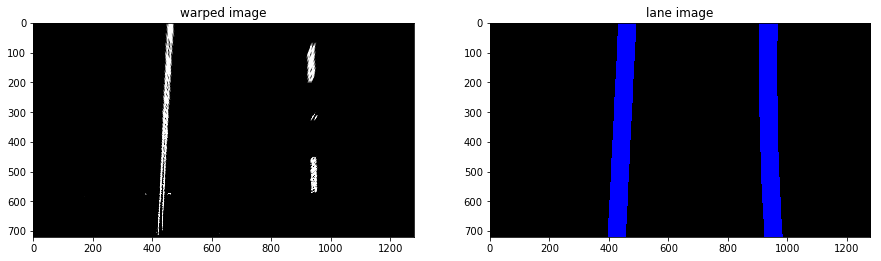

In [11]:
test_lane = Line(nwindows=9, win_width=40, mtx=mtx, dist=dist, M=M, Minv=Minv)
lane_img = np.zeros_like(warped_img)
lane_img, curvature, dist = test_lane.find_lane(undistorted_img)
print('position: ', dist)
print('centroids(left): ', test_lane.previous_centroids[0])
print('curvature(left): ', curvature[0])
print('centroids(right): ', test_lane.previous_centroids[1])
print('curvature(right): ', curvature[1])

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.title('warped image')
plt.imshow(warped_img, cmap='gray')
plt.subplot(1,2,2)
plt.title('lane image')
plt.imshow(lane_img, cmap='gray')

In [54]:
class Line():
    def __init__(self, nwindows, win_width, mtx, dist, M, Minv):
        self.previous_fit_l = []
        self.previous_fit_r = []
        self.previous_fit = []
        self.previous_centroids = []
        self.allx = [] 
        self.ally = [] 
        self.mtx = mtx 
        self.dist= dist 
        self.M = M 
        self.Minv= Minv 
        self.nwindows = nwindows
        self.win_width = win_width
    def find_refwin(self, window_centroids, window_boole):
        num = len(window_centroids)
        center = 0
        for i in range(num, 0, -1):
            if window_boole[i-1] == True:
                center = window_centroids[i-1]
                break
        return center
    def find_centroids(self, img, space_search=100): 
        window = np.ones(self.win_width)
        window_centroids_l = []
        window_centroids_r = []
        window_boole_l = []
        window_boole_r = []
        win_height = img.shape[0]/self.nwindows 
        bottom_sum_l = np.sum(img[int(3*img.shape[0]/4):,:640], axis=0)
        bottom_sum_r = np.sum(img[int(3*img.shape[0]/4):,640:], axis=0)
        conv_signal_l = np.convolve(window, bottom_sum_l)
        conv_signal_r = np.convolve(window, bottom_sum_r)
        center_l = int(np.argmax(conv_signal_l)-self.win_width/2)
        center_r = int(np.argmax(conv_signal_r)-self.win_width/2)+640
        previous_centroids = np.array(self.previous_centroids)
        if self.previous_centroids==[] or abs(center_l-previous_centroids[0,0])<50:
            window_centroids_l.append(center_l)
        else:
            window_centroids_l.append(previous_centroids[0,0])
        if self.previous_centroids==[] or abs(center_r-previous_centroids[1,0])<50:
            window_centroids_r.append(center_r)
        else:
            window_centroids_r.append(previous_centroids[1,0])
        window_boole_l.append(True)
        window_boole_r.append(True)
        for i in range(1, self.nwindows):
            window_ref_l = self.find_refwin(window_centroids_l, window_boole_l)
            window_ref_r = self.find_refwin(window_centroids_r, window_boole_r)
            min_index_l = int(max(window_ref_l-space_search,0))
            max_index_l = int(min(window_ref_l+space_search,640))
            min_index_r = int(max(window_ref_r-space_search,640))
            max_index_r = int(min(window_ref_r+space_search,img.shape[1]))
            start_y = int(img.shape[0]-(i+1)*win_height)
            end_y = int(img.shape[0]-i*win_height)
            image_layer_l = np.sum(img[start_y:end_y, min_index_l:max_index_l],axis=0)
            image_layer_r = np.sum(img[start_y:end_y, min_index_r:max_index_r],axis=0)
            conv_signal_l = np.convolve(window, image_layer_l)
            conv_signal_r = np.convolve(window, image_layer_r)
            offset = int(self.win_width/2)
            window_center_l = np.argmax(conv_signal_l)+min_index_l-offset
            window_center_r = np.argmax(conv_signal_r)+min_index_r-offset
            window_centroids_l.append(window_center_l)
            window_centroids_r.append(window_center_r)
            if abs(window_center_l-window_ref_l)<100:
                window_boole_l.append(True)
            else:
                window_boole_l.append(False)
            if abs(window_center_r-window_ref_r)<100:
                window_boole_r.append(True)
            else:
                window_boole_r.append(False)
        window_centroids = [window_centroids_l,window_centroids_r]
        window_boole = [window_boole_l, window_boole_r]
        self.previous_centroids = window_centroids
        return np.array(window_centroids), np.array(window_boole)
    def find_xy(self, img, window_centroids, window_boole):
        self.allx[:] = []
        self.ally[:] = []
        binary_img = img
        win_height = img.shape[0]/self.nwindows 
        nonzero = binary_img.nonzero()
        nonzeroy = nonzero[0]
        nonzerox = nonzero[1]
        for window in range(2):
            index = 0
            x = []
            y = []
            for i in range(9):
                if window_boole[window,i] == True:
                    center = window_centroids[window,i]
                    start_y = int(img.shape[0]-(i+1)*win_height)
                    end_y = int(img.shape[0]-i*win_height)
                    start_x = int(max(center-self.win_width/2, 0))
                    end_x = int(min(center+self.win_width/2, img.shape[1]))
                    binary_img[start_y:end_y,start_x:end_x] = 128
                    for idx in range(len(nonzerox)):
                        if nonzeroy[idx]>start_y and nonzeroy[idx]<end_y:
                            if nonzerox[idx]>start_x and nonzerox[idx]<end_x:
                                x.append([index,nonzerox[idx]])
                                y.append([index,nonzeroy[idx]])
                                index += 1
            self.allx.append(x)
            self.ally.append(y)
        return binary_img
    def line_fit(self, img, window_boole, margin=30):
        ym_per_pix = 23/img.shape[0]
        previous_fit_l = self.previous_fit_l
        previous_fit_r = self.previous_fit_r
        num_win_l = len([i for i in window_boole[0] if i])
        num_win_r = len([i for i in window_boole[1] if i])
        num_win = [num_win_l, num_win_r]
        out_img = np.zeros((img.shape[0],img.shape[1],3), dtype=np.uint8)
        total_fit = []
        for idx in range(2):
            if num_win[idx]>1:
                y = np.array(self.ally[idx])
                x = np.array(self.allx[idx])
                py = y[:,1]
                px = x[:,1]
                ransac = linear_model.RANSACRegressor(residual_threshold=40, random_state=50)
                ransac.fit(y,x)
                inlier_mask = ransac.inlier_mask_
                outlier_mask = np.logical_not(inlier_mask)
                fit = np.polyfit(py[inlier_mask], px[inlier_mask], 2)
                if idx == 0: #left
                    self.previous_fit_l = fit
                elif idx == 1:#right
                    self.previous_fit_r = fit
                ploty= np.linspace(0, img.shape[0]-1, img.shape[0])
                plotx = fit[0]*ploty**2+fit[1]*ploty+fit[2]
                line_window1 = np.array([np.transpose(np.vstack([plotx-margin, ploty]))])
                line_window2 = np.array([np.flipud(np.transpose(np.vstack([plotx+margin,ploty])))])
                line_pts = np.hstack((line_window1, line_window2))
                out_img[y[:,1], x[:,1],:] = [255, 0, 0]
                out_img[py[inlier_mask], px[inlier_mask], :]= [255, 255, 0]
                out_img[py[outlier_mask], px[outlier_mask], :] = [0, 255, 255]
                cv2.fillPoly(out_img, np.int_([line_pts]), (0, 0, 255))
                total_fit.append(fit)
            else:
                if idx == 0: #left
                    fit = self.previous_fit_l
                elif idx == 1:#right
                    fit = self.previous_fit_r
                ploty= np.linspace(0, img.shape[0]-1, img.shape[0])
                plotx = fit[0]*ploty**2+fit[1]*ploty+fit[2]
                line_window1 = np.array([np.transpose(np.vstack([plotx-margin, ploty]))])
                line_window2 = np.array([np.flipud(np.transpose(np.vstack([plotx+margin,ploty])))])
                line_pts = np.hstack((line_window1, line_window2))
                cv2.fillPoly(out_img, np.int_([line_pts]), (255, 0, 255))
                total_fit.append(fit)
        ploty= np.linspace(0, img.shape[0]-1, img.shape[0])
        left_plotx = total_fit[0][0]*ploty**2+total_fit[0][1]*ploty+total_fit[0][2]
        right_plotx= total_fit[1][0]*ploty**2+total_fit[1][1]*ploty+total_fit[1][2]
        line_window1 = np.array([np.transpose(np.vstack([left_plotx+margin, ploty]))])
        line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_plotx-margin,ploty])))])
        line_pts = np.hstack((line_window1, line_window2))
        cv2.fillPoly(out_img, np.int_([line_pts]), (255, 0, 0))
        left_curvature, right_curvature, dist = self.get_curvature(total_fit) 
#         left_curvature = self.get_curvature(total_fit[0]) 
#         right_cervature = self.get_curvature(total_fit[1])
#         dist = self.get_dist_center(total_fit)
        return out_img, np.array(total_fit), np.array([left_curvature, right_curvature]), dist
    def equalizeHist(self, img):
        output = np.copy(img)
        output[:,:,0]= cv2.equalizeHist(output[:,:,0])
        output[:,:,1]= cv2.equalizeHist(output[:,:,1])
        output[:,:,2]= cv2.equalizeHist(output[:,:,2])
        return output
    def undistort_img(self, img, mtx, dist):
        return cv2.undistort(img, mtx, dist, None, mtx)
    def warp_image(self, img, mtx):
        flag=cv2.INTER_LINEAR
        img_size = (img.shape[1], img.shape[0])
        return cv2.warpPerspective(img, mtx, img_size, flag)
    def gradient_x(self, img, kernel_size = 3, thresh=(0,255)):
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel_size)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        return sxbinary
    def get_curvature(self, fit):
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
        left_fit = fit[0]
        right_fit = fit[1]
        leftx = np.array([left_fit[0]*y**2+left_fit[1]*y+left_fit[2]+ np.random.randint(-50, high=51) for y in ploty])
        rightx = np.array([right_fit[0]*y**2+right_fit[1]*y+right_fit[2]+ np.random.randint(-50, high=51) for y in ploty])
        left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
        y_eval = np.max(ploty) 
        if left_fit[0] != 0:
            left_curv = ((1+(2*left_fit_cr[0]*y_eval+left_fit_cr[1])**2)**1.5)/np.absolute(2*left_fit_cr[0])
        else:
            left_curv = np.inf
        if right_fit[0] != 0:
            right_curv = ((1+(2*right_fit_cr[0]*y_eval+right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])
        else:
            right_curv = np.inf
            
        dist = self.get_dist_center(np.array([left_fit_cr, right_fit_cr]))
        return left_curv, right_curv, dist
    def get_dist_center(self, fit):
        xm_per_pix = 3.7/700
        real_center = (fit[1][2]+fit[0][2])/2
        dist = (640*xm_per_pix-real_center)
#         dist = (640-real_center)*xm_per_pix
        return dist
    def preprocess_img(self, img, sobel_ksize=3):
        img = np.copy(img) #RGB
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        l_channel = hsv[:,:,1]
        s_channel = hsv[:,:,2]
        light_mask = np.zeros_like(l_channel)
        light_mask[(s_channel>=5) & (l_channel>=130)] = 1
        gradx_l = self.gradient_x(l_channel, sobel_ksize, (25, 100))
        gradx_s = self.gradient_x(s_channel, sobel_ksize, (10, 100))
        combined = np.zeros_like(gradx_s)
        combined[((gradx_l == 1) | (gradx_s == 1)) & (light_mask == 1)] = 1
        color_binary = np.uint8(combined*255)
        return color_binary 
    def find_lane(self, img, sobel_ksize=3):
        undistorted_img = self.undistort_img(img, self.mtx, self.dist)
        preprocessed_img = self.preprocess_img(undistorted_img, sobel_ksize)
        perspective_img = self.warp_image(preprocessed_img, self.M)
        window_centroids, window_boole = self.find_centroids(perspective_img)
        binary_img = self.find_xy(perspective_img, window_centroids, window_boole)
        lanes_img, fit, curvature, dist = self.line_fit(perspective_img, window_boole)
        lanes_img = self.warp_image(lanes_img, self.Minv)
        cv2.putText(lanes_img, 'left: a: %.2f b: %.2f c: %.2f curvature: %.1f'%(fit[0,0], fit[0,1], fit[0,2], curvature[0]), (50,50), cv2.FONT_HERSHEY_COMPLEX , 1.0, (255,255,255))
        cv2.putText(lanes_img, 'right: a: %.2f b: %.2f c: %.2f curvature: %.1f'%(fit[1,0], fit[1,1], fit[1,2], curvature[1]), (50,90), cv2.FONT_HERSHEY_COMPLEX , 1.0, (255,255,255))
        cv2.putText(lanes_img, 'dist: %.2f'%dist, (50,130), cv2.FONT_HERSHEY_COMPLEX , 1.0, (255,255,255))
        output_img = cv2.addWeighted(undistorted_img, 1, lanes_img, 0.8, 0)
        return output_img 

## Save frame for testing

In [13]:
# clip_test = VideoFileClip("harder_challenge_video.mp4").iter_frames()
# clip_test = VideoFileClip("challenge_video.mp4").iter_frames()
clip_test = VideoFileClip("project_video.mp4").subclip(20,30).iter_frames()
# clip_test = VideoFileClip("harder_challenge_video.mp4").subclip(0,10).iter_frames()
i = 0
for frame in clip_test:
    fname = './output_images/harder_challenge_frame'+str(i)+'.jpg'
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.imwrite(fname, frame)
    i = i+1

In [14]:
num_test_pic = len(os.listdir('./output_images/'))
print(num_test_pic)

252


In [53]:
test_lane = Line(nwindows=9, win_width=40, mtx=mtx, dist=dist, M=M, Minv=Minv)
# for i in tqdm(range(num_test_pic)):
for i in tqdm(range(20)):
    filename = './output_images/harder_challenge_frame'+str(i)+'.jpg'
    img = cv2.imread(filename)
    out_img = np.zeros_like(img)
    out_img = test_lane.find_lane(img)
    cv2.imwrite('./test_out/harder_challenge_frame'+str(i)+'.jpg', out_img)

100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


## Process video

In [55]:
video_lane = Line(nwindows=9, win_width=40, mtx=mtx, dist=dist, M=M, Minv=Minv)

def process_image(img):
    out_img = np.zeros_like(img)
    out_img = video_lane.find_lane(img)
    return out_img 

In [56]:
video_test_output = 'videos_output/project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(20,35)
clip1 = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip1.write_videofile(video_test_output, audio=False)

[MoviePy] >>>> Building video videos_output/project_video_output.mp4
[MoviePy] Writing video videos_output/project_video_output.mp4


100%|█████████▉| 1260/1261 [06:28<00:00,  3.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos_output/project_video_output.mp4 

CPU times: user 7min 19s, sys: 2.62 s, total: 7min 21s
Wall time: 6min 28s


In [57]:
video_test_output = 'videos_output/challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4").subclip(0,4)
clip1 = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip1.write_videofile(video_test_output, audio=False)

[MoviePy] >>>> Building video videos_output/challenge_video_output.mp4
[MoviePy] Writing video videos_output/challenge_video_output.mp4


100%|██████████| 120/120 [00:23<00:00,  6.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos_output/challenge_video_output.mp4 

CPU times: user 28.6 s, sys: 404 ms, total: 29 s
Wall time: 24.5 s


In [ ]:
video_test_output = 'videos_output/harder_challenge_video_output.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")#.subclip(0,10)
clip1 = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip1.write_videofile(video_test_output, audio=False)